In [6]:
#
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [10]:
batch_x, train_y= mnist.train.next_batch(55000) 
print(batch_x.shape)

(55000, 784)


In [46]:

class SOM(object):
    def __init__(self, m, n):
        self.net_dim = np.array([m, n])
        self.weights = None
        self.hit_map = np.zeros([self.net_dim[0], self.net_dim[1]])
        self.init_radius = np.max(self.net_dim)/2
        self.umatrix = np.zeros([self.net_dim[0], self.net_dim[1]])
        self.umat_2 = np.zeros([self.net_dim[0]*2 - 1, self.net_dim[1]*2 - 1])
        self.bmu_list = None
        self.label_map = np.zeros([self.net_dim[0], self.net_dim[1]]) + -1
        self.classif_log=None # matrix for storing data for each neu, #times it becomed BMU for each class
        self.neu_class=np.zeros([m*n])# store class for each neuron 
        self.trainAccuracy=None
        self.testAccuracy=None

    def fit_model(self, train_x, train_y=None, init_lr=0.1, epochs=100):
        # Initializing the weight matrix
        self.weights = np.random.random((self.net_dim[0], self.net_dim[1], train_x.shape[1]))
        self.bmu_list = np.zeros(train_x.shape[0])
        time_constant = epochs/np.log(self.init_radius)
        
        if not (train_y is None):
            #print("np.unique(train_y).shape[0]",np.unique(train_y).shape[0])
            self.classif_log=np.zeros([np.unique(train_y).shape[0] , self.net_dim[0]*self.net_dim[1]])

        for epoch in range(epochs):
            print('Processing epoch:{}'.format(epoch))
            """decay the radius and the learning rate"""
            if epoch != 0:
                radius = SOM.decay_radius(self.init_radius,epoch, time_constant)
                lr = SOM.decay_learning_rate(init_lr, epoch, epochs)

            else:
                radius = self.init_radius
                lr = init_lr

            #print("train_x.shape[0]",train_x.shape[0])            
            randlist=random.sample(range(train_x.shape[0]), train_x.shape[0])
            for t in range(train_x.shape[0]):

                # Picking a random pattern
                r = randlist[t]                
                # Finding the bmu for the random pattern
                bmu_index, bmu = self.find_bmu(train_x[r, :])
                #print("bmu_index : ",bmu_index) 
                self.bmu_list[r] = bmu_index[0]*self.weights.shape[1] + bmu_index[1]
                #print("self.bmu_list[r] :: ",self.bmu_list[r])

                # updating the weights
                for i in range(self.net_dim[0]):
                    for j in range(self.net_dim[1]):
                        w = self.weights[i, j, :]
                        w_bmu_dist = SOM.get_distance(w, bmu)

                        h = self.get_gaussian_membership(w_bmu_dist, radius)
                        delta_w = (lr * h * (train_x[r, :] - w))
                        new_w = w + delta_w
                        self.weights[i, j, :] = new_w                        
                        if np.isnan(self.weights).any():
                            print(' weights NaN at epoch {}'.format(epoch))

                            return
                        # print('\n')
            ##
            if not (train_y is None) :       
                for t in range(train_x.shape[0]):
                    bmu_index, bmu = self.find_bmu(train_x[t, :])
                    self.bmu_list[t] = bmu_index[0]*self.weights.shape[1] + bmu_index[1]
                    #print("self.bmu_list[r]",self.bmu_list[r])
                    self.classif_log[int(train_y[t]),int(self.bmu_list[t])]=(self.classif_log[int(train_y[t]),int(self.bmu_list[t])])+1
                print("Train Accuracy",(sum(self.classif_log.max(axis=0))*100)/ (train_x.shape[0]) )
                self.classif_log=np.zeros([np.unique(train_y).shape[0] , self.net_dim[0]*self.net_dim[1]])
                self.trainAccuracy=(sum(self.classif_log.max(axis=0))*100)/ (train_x.shape[0])
 
        if not (train_y is None) :       
            for t in range(train_x.shape[0]):
                bmu_index, bmu = self.find_bmu(train_x[t, :])
                self.bmu_list[t] = bmu_index[0]*self.weights.shape[1] + bmu_index[1]
                #print("self.bmu_list[r]",self.bmu_list[r])
                """                    
                print("bla", bmu_index,bmu ," t",t) # bla [0, 2] [-0.002496    0.00031421 -0.00322767] print("Train y val :",int(train_y[t]))
                print("self.bmu_list :",int(self.bmu_list[t]))
                """
                #print("int(train_y[t])",int(train_y[t]) )
                #print("int(self.bmu_list[t])",int(self.bmu_list[t]))
                self.classif_log[int(train_y[t]),int(self.bmu_list[t])]=(self.classif_log[int(train_y[t]),int(self.bmu_list[t])])+1
                        
            print("Check \n",self.classif_log)        
            self.neu_class=self.classif_log.argmax(axis=0) 
            print("self.neu_class",self.neu_class)
            print("Train Accuracy",(sum(self.classif_log.max(axis=0))*100)/ (train_x.shape[0]) )
            self.trainAccuracy=(sum(self.classif_log.max(axis=0))*100)/ (train_x.shape[0])
        self.set_umatrix()
        self.set_hitmap()
        #now test for accuracy
        #if train_y is not None:
            #self.set_label_map(train_y)#this needs checking cz it prints something 
        
    def test_model(self, test_x, test_y=None):
        
        correct=0;
        
        for t in range(test_x.shape[0]):
            bmu_index, bmu = self.find_bmu(test_x[t, :])
            neu_no=bmu_index[0]*self.weights.shape[1] + bmu_index[1]
            #print("neu_no : ",neu_no)
            class_label=self.neu_class[neu_no]

            if(class_label==test_y[t]):
                correct=correct+1
        print("Test Accuracy : ", (correct*100/test_x.shape[0]))
        self.testAccuracy=(correct*100/test_x.shape[0])



    def find_bmu(self, x):
        min_dist = float('inf')
        bmu_index = [-1, -1]
        bmu = self.weights[0, 0, :]
        for i in range(self.net_dim[0]):
            for j in range(self.net_dim[1]):
                w = self.weights[i, j, :]
                d = SOM.get_distance(x, w)
                #print("d : ",d)
                if d < min_dist:
                    min_dist = d
                    bmu_index = [i, j]
                    bmu = w

        return bmu_index, bmu

    def get_gaussian_membership(self, squared_distance_from_bmu, radius):
        h = np.exp(-squared_distance_from_bmu/(2*(radius**2)))
        # h = np.exp(squared_distance_from_bmu/(2*(radius**2)))
        # print('h:{}'.format(h))
        return h

    def set_hitmap(self):
        unique, counts = np.unique(self.bmu_list, return_counts=True)
        #print("unique",unique)
        #print("counts",counts)
        bmu_dict = dict(zip(unique.astype(int), counts))

        for bmu, count in bmu_dict.items():
            i = int(bmu / self.label_map.shape[1])
            j = bmu % self.label_map.shape[1]
            self.hit_map[i, j] = count
            
        #print(np.shape(self.hit_map))

    def set_label_map(self, train_y):
        # print(self.label_map)

        unique, counts = np.unique(self.bmu_list, return_counts=True)
        bmu_dict = dict(zip(unique.astype(int), counts))
        print(bmu_dict)

        for bmu, count in bmu_dict.items():
            # print('bmu: {}, count: {}'.format(bmu, count))
            # print(self.bmu_list[self.bmu_list == bmu])
            idx = np.where(self.bmu_list == bmu)
            unique_labels, label_counts = np.unique(train_y[idx], return_counts=True)

            labels_dict = dict(zip(unique_labels.astype(int), label_counts))
            # print(labels_dict)

            import operator
            # print(max(labels_dict.items(), key=operator.itemgetter(1))[0])

            i = int(bmu / self.label_map.shape[1])
            j = bmu % self.label_map.shape[1]

            self.label_map[i, j] = max(labels_dict.items(), key=operator.itemgetter(1))[0]

    @classmethod
    def get_distance(cls, x1, x2):
        return np.sum((x1 - x2) ** 2)

    @classmethod
    def decay_radius(cls, init_radius, e, time_constant):
        return init_radius * np.exp(-e / time_constant)

    @classmethod
    def decay_learning_rate(cls, init_lr, e, num_epochs):
        return init_lr * np.exp(-e / num_epochs)

    @classmethod
    def draw_square(cls, x, y, dim, color):
        rect = plt.Rectangle((x, y), dim, dim, fc=color)

        return rect

    def show_hitmap(self, show_hits=False):
        print("show hit map")
        #fig, ax = plt.subplots()
        plt.figure()
        plt.imshow(self.hit_map, cmap='jet')
        plt.title('Hit map')
        plt.colorbar()        
        if show_hits:
            for i in range(self.net_dim[0]):
                for j in range(self.net_dim[1]):
                    c = self.hit_map[j,i]
                    plt.text(i, j, str(c), va='center', ha='center')    
        plt.show()
        
    def show_umatrix(self):
        plt.figure()
        plt.imshow(self.umatrix, cmap='jet')
        plt.title('U-Matrix')
        plt.colorbar()
        plt.draw()
        plt.show()

    def set_umatrix(self, nbhd='neumann'):
        for i in range(self.weights.shape[0]):
            for j in range(self.weights.shape[1]):
                self.umatrix[i, j] = self.calculate_average_distance([i, j], nbhd=nbhd)

    def calculate_average_distance(self, index, nbhd='neumann'):
        avg_distance = -1

        if nbhd == 'neumann':
            n = np.zeros([4])
            div = 4
            x = index[0]
            y = index[1]
            # Above
            if (x - 1) >= 0:
                n[0] = np.sqrt(SOM.get_distance(self.weights[x - 1, y, :], self.weights[x, y, :]))
            else:
                div -= 1
            # Below
            if (x + 1) < self.weights.shape[0]:
                n[1] = np.sqrt(SOM.get_distance(self.weights[x + 1, y, :], self.weights[x, y, :]))
            else:
                div -= 1
            # Left
            if (y - 1) >= 0:
                n[2] = np.sqrt(SOM.get_distance(self.weights[x, y - 1, :], self.weights[x, y, :]))
            else:
                div -= 1
            # Right
            if (y + 1) < self.weights.shape[1]:
                n[3] = np.sqrt(SOM.get_distance(self.weights[x, y + 1, :], self.weights[x, y, :]))
            else:
                div -= 1

            avg_distance = np.sum(n) / div
        elif nbhd == 'moore':
            # TODO implement for moore neighborhood
            pass

        else:
            print('Not a valid Neighborhood')

        return avg_distance

    def set_umat_2(self):
        # TODO: Need to optimize this code
        r = 0
        for i in range(self.net_dim[0]):
            c = 0
            for j in range(self.net_dim[1]):
                if c+1 < self.umat_2.shape[1]:
                    self.umat_2[r, c+1] = SOM.get_distance(self.weights[i, j, :], self.weights[i, j+1, :])

                if r+1 < self.umat_2.shape[0]:
                    self.umat_2[r+1, c] = SOM.get_distance(self.weights[i, j, :], self.weights[i+1, j, :])
                c = c+2
            r = r+2

        temp = np.zeros([self.umat_2.shape[0], self.umat_2.shape[1], self.weights.shape[2]])
        r = 0
        for i in range(0, self.umat_2.shape[0], 2):
            c = 0
            for j in range(0, self.umat_2.shape[1],2):
                temp[i, j] = self.weights[r, c, :]

                c += 1
            r += 1

        for i in range(self.umat_2.shape[0]):
            for j in range(self.umat_2.shape[1]):
                if i % 2 != 0 and j % 2 != 0:
                    self.umat_2[i, j] = (SOM.get_distance(temp[i-1, j-1, :], temp[i+1, j+1, :]) +
                                         SOM.get_distance(temp[i-1, j+1, :], temp[i+1, j-1, :]))/2

    def show_umatrx_2(self, size=2):
        max_dist = np.max(self.umat_2)
        print(max_dist)
        cmap = matplotlib.pyplot.get_cmap('jet', lut=256)
        plt.figure()
        plt.imshow(self.umat_2, cmap='jet')
        plt.title('U-Matrix')
        plt.colorbar()
        plt.draw()
        plt.show()
        
    def print_save_weights(self,fileName):
        """
        for i in range(self.weights.shape[0]):
            print(self.weights[i,:]) 
        """  
        np.save(fileName,self.weights)
        #print("load: \n", np.load('maximums.npy'))

def standardize_data(X):
    x_norm = (X - X.mean(axis=0)) / X.std(axis=0)
    return x_norm
    from tempfile import TemporaryFile   


In [19]:

if __name__ == '__main__':
    som = SOM(3, 3)

    train_x, train_y= mnist.train.next_batch(3000)
    '''
    print(type(train_x))
    print(np.shape(train_x))
    print(type(train_y))
    print(np.shape(train_y))
    

    train_y=train_y.argmax(axis=1) 
    print(train_y)
    print(train_y.shape)
    print(train_x.shape)
    '''
    from numpy import genfromtxt
    train_x = genfromtxt('traindata.csv', delimiter=',')
    print(type(train_x))
    print(np.shape(train_x))

    train_y = genfromtxt('traindata_label.csv', delimiter=',')
    print(type(train_y))
    print(np.shape(train_y))
    

    som.fit_model(train_x,train_y, epochs=5)


<class 'numpy.ndarray'>
(3000, 784)
<class 'numpy.ndarray'>
(3000,)
Processing epoch:0
Train Accuracy 47.3333333333
Processing epoch:1
Train Accuracy 51.9333333333
Processing epoch:2
Train Accuracy 57.1333333333
Processing epoch:3
Train Accuracy 57.7666666667
Processing epoch:4
Train Accuracy 58.0
Check 
 [[   0.   13.    3.    3.   11.  226.   44.    0.    0.]
 [   0.    1.    2.    1.    1.    0.    0.  295.    0.]
 [   9.    4.   11.  203.   17.    3.    5.   45.    3.]
 [   0.    0.   38.   16.  213.    1.    7.   23.    2.]
 [ 112.    9.    1.    4.    0.    1.    3.   21.  149.]
 [  20.    1.   60.    1.  115.    4.   29.   52.   18.]
 [   0.  133.    0.    0.    2.    0.  152.   11.    2.]
 [ 197.    2.    1.    2.    1.    2.    0.   31.   64.]
 [   7.    4.  167.    6.   55.    2.    3.   37.   19.]
 [ 117.    0.    6.    1.    2.    4.    0.   16.  154.]]
self.neu_class [7 6 8 2 3 0 6 1 9]
Train Accuracy 58.0


In [20]:
test_x = genfromtxt('testdata0.csv', delimiter=',')
print(type(test_x))
print(np.shape(test_x))

test_y = genfromtxt('testdata_class.csv', delimiter=',')
print(type(test_y))
print(np.shape(test_y))

som.test_model(test_x,test_y)
som.testAccuracy

<class 'numpy.ndarray'>
(10000, 784)
<class 'numpy.ndarray'>
(10000,)
Test Accuracy :  58.5


58.5

In [24]:
data1=genfromtxt('KDDTrainset.csv',delimiter=",")

In [47]:
print(len(data1))
print(np.shape(data1))
print(data1[1,:])

125973
(125973, 44)
[  0.00000000e+00   2.00000000e+00   4.00000000e+01   1.00000000e+00
   1.46000000e+02   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.30000000e+01   1.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   8.00000000e-02   1.50000000e-01   0.00000000e+00   2.55000000e+02
   1.00000000e+00   0.00000000e+00   6.00000000e-01   8.80000000e-01
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.20000000e+01   1.50000000e+01   1.00000000e+00]


In [48]:
train_x=data1[0:20000,0:41]
print(np.shape(train_x))
train_y=data1[0:20000,43]
print(np.shape(train_y))

(20000, 41)
(20000,)


In [49]:
som = SOM(8, 8)

In [50]:
som.fit_model(train_x,train_y, epochs=5)

Processing epoch:0
Train Accuracy 94.94
Processing epoch:1
Train Accuracy 95.22
Processing epoch:2
Train Accuracy 94.335
Processing epoch:3
Train Accuracy 94.76
Processing epoch:4
Train Accuracy 94.805
Check 
 [[  6.00000000e+01   1.00000000e+00   1.00000000e+00   4.20000000e+01
    4.60000000e+01   3.38900000e+03   0.00000000e+00   0.00000000e+00
    2.34000000e+02   2.00000000e+00   0.00000000e+00   1.50000000e+01
    0.00000000e+00   1.50000000e+01   2.00000000e+00   0.00000000e+00
    9.00000000e+00   3.20000000e+01   0.00000000e+00   1.50000000e+02
    1.02000000e+02   3.00000000e+00   4.00000000e+00   3.00000000e+00
    0.00000000e+00   0.00000000e+00   5.00000000e+00   2.00000000e+00
    1.00000000e+00   4.00000000e+00   0.00000000e+00   2.00000000e+01
    0.00000000e+00   2.00000000e+00   2.10000000e+01   1.08000000e+02
    9.10000000e+01   8.00000000e+00   0.00000000e+00   3.00000000e+00
    7.00000000e+00   1.18000000e+03   1.70000000e+01   2.60000000e+01
    6.80000000e+01  

show hit map


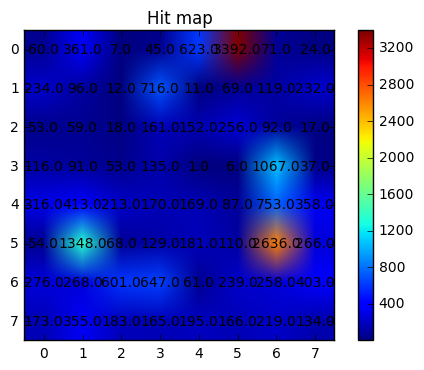

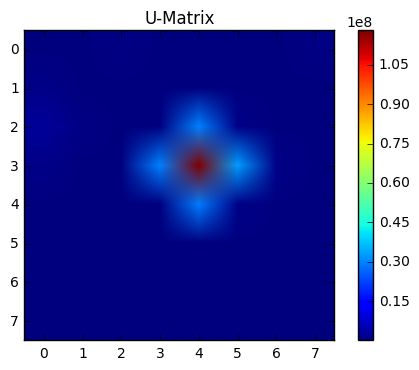

In [51]:
som.show_hitmap(True)
plt.show()

som.set_umatrix()
som.show_umatrix()

In [133]:
test_x=data1[20001:40000,0:41]
print(np.shape(train_x))
test_y=data1[20001:40000,43]
print(np.shape(train_y))
som.test_model(test_x,test_y)
som.testAccuracy

(20000, 41)
(20000,)
Test Accuracy :  94.82474123706186


94.82474123706186

In [53]:
som.print_save_weights('bla')

In [55]:
points=np.load('bla.npy')

In [56]:
print(np.shape(points))

(8, 8, 41)


In [76]:
#create the data set using BMUs

BMUList=[]
for i in range(0,8):
    for j in range(0,8):        
        BMUList.append(points[i,j,:])


In [77]:
print(np.shape(BMUList))

(64, 41)


In [64]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 0],
              [4, 2], [4, 4], [4, 0]])
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans.labels_

array([0, 0, 0, 1, 1, 1], dtype=int32)

In [65]:
kmeans.predict([[0, 0], [4, 4]])

array([0, 1], dtype=int32)

In [66]:
kmeans.cluster_centers_

array([[ 1.,  2.],
       [ 4.,  2.]])

In [92]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(BMUList)
labels_of_BMUs=kmeans.labels_
print(np.shape(labels_of_BMUs))

(64,)


In [91]:
bmu_index, bmu = som.find_bmu(train_x[8, :])
print(bmu_index) # [0,0].....[7,7]
print(bmu)

[0, 5]
[  2.43269240e-002   1.00000000e+000   3.43661676e+001   3.25290616e+000
   6.89460759e-006   4.17735588e-013   3.45845952e-323   3.47921334e-077
   3.45845952e-323   9.11865261e-042   3.45845952e-323   1.14910125e-006
   3.45845952e-323   3.45845952e-323   3.45845952e-323   3.45845952e-323
   3.45845952e-323   3.45845952e-323   3.45845952e-323   3.45845952e-323
   3.45845952e-323   3.45845952e-323   2.58532168e+002   1.11366180e+001
   7.66582434e-001   7.64170433e-001   2.33078916e-001   2.35827243e-001
   4.36037644e-002   8.46380563e-002   5.04643406e-007   2.54591027e+002
   1.20260267e+001   4.66482147e-002   9.15732470e-002   2.74071921e-004
   3.45845952e-323   7.66459349e-001   7.64171608e-001   2.32136309e-001
   2.35827243e-001]


In [119]:
#for each data point store the cluster label
data_cluster_list=np.zeros(20000);
for i in range(0,20000):
    bmu_index, bmu = som.find_bmu(train_x[i, :])    
    data_cluster_list[i]=(labels_of_BMUs[((bmu_index[0])*8) +bmu_index[1]]);
print(data_cluster_list) 
print(type(data_cluster_list))

[ 0.  0.  0. ...,  0.  0.  0.]
<class 'numpy.ndarray'>


In [120]:
ii = np.where(data_cluster_list == 0)
print('________________________')
print(ii)

________________________
(array([    0,     1,     2, ..., 19997, 19998, 19999]),)


In [122]:
#seperate train data for k clusters 
n_clusters=10;
datasets=[];
for i in range(0,10):    
    searchval = i
    ii = np.where(data_cluster_list == i)[0]
    print('________________________')
    print(ii)
    datasets.append(train_x[ii, :])
    


________________________
[    0     1     2 ..., 19997 19998 19999]
________________________
[1038]
________________________
[ 7040  7307  7429  8492 17637 19338]
________________________
[  303   805  1046  1244  1510  1691  2160  2428  2477  2565  2722  3229
  3263  3337  3623  3686  4163  5122  5261  6070  6109  6693  6918  7300
  8581  9033  9235  9435  9909 10569 12133 12327 12873 13060 13200 13235
 13888 15339 15382 15723 15808 16145 16451 16812 16976 17023 17154 17498
 17848 18750 19199 19558 19856]
________________________
[ 4934  8702 14703 14712 15456 17871 19771]
________________________
[ 3104  3341  5544  5914  6001  7893  8814  9095  9200 10646 11108 11400
 12518 14365 14570 14722 17092 17098 18964 19011 19431 19465 19500 19966]
________________________
[ 1307  2312  4677  5708 11759 12596 14876 17692 17927 19052 19385]
________________________
[ 4194  5794  6303  7965  8894 13168 14717 14760 16615 16691 17560 19101]
________________________
[  405  1079  1333  2035  4784

In [124]:
print(np.shape(datasets[1]))

(1, 41)


In [136]:
#train OCSVM for each dataset
from sklearn import svm
aa = list()

#create one class SVM for each data cluster
for i in range(10):
    aa.append(svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.1))
    
for i in range(10):
    aa[i].fit(datasets[i])
    


"""
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size
"""

'\ny_pred_train = clf.predict(X_train)\ny_pred_test = clf.predict(X_test)\ny_pred_outliers = clf.predict(X_outliers)\nn_error_train = y_pred_train[y_pred_train == -1].size\nn_error_test = y_pred_test[y_pred_test == -1].size\nn_error_outliers = y_pred_outliers[y_pred_outliers == 1].size\n'

In [134]:
#for each new data , check with all 10 classifieir 

